<a href="https://colab.research.google.com/github/riskingsun/analytics/blob/master/FirstFineTuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<Axes: >

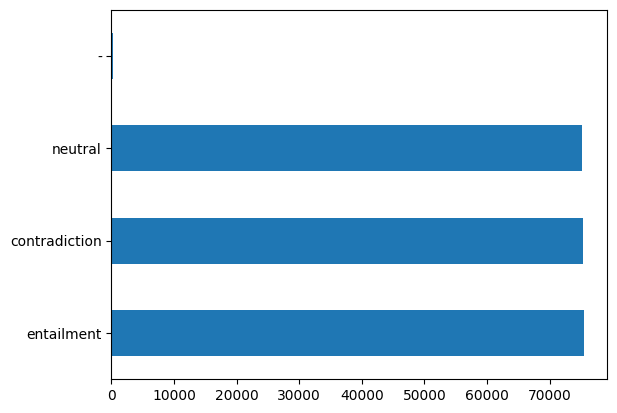

In [9]:
# https://www.kdnuggets.com/fine-tuning-llamav2-with-qlora-on-google-colab-for-free
import pandas as pd


#df = pd.read_csv('snli_1.0_train_matched.csv', sep='\t')
#df = pd.read_csv('./sp-data/firstfinetuning/snli_1.0_train.txt', sep='\t')
df = pd.read_csv('./drive/MyDrive/AAAMachineLearning/Projects/FineTuning/data/snli_1.0_train.txt', sep='\t')
df['gold_label'].value_counts().plot(kind='barh')

In [10]:
df[df['gold_label'] == 'contradiction'].sample(10)[['sentence1', 'sentence2']]

,sentence1,sentence2
68788,A girl in jean shorts and a floral blue and gr...,a girl is sleeping
100653,Three girls in winter coats are outside in a s...,The girls are wearing bathing suits.
60845,A woman walks her dog in a marketplace.,The woman is walking a cat.
86583,A priest is speaking into a microphone within ...,The church is packed
224792,People enjoying themselves in the park.,A group of people are doing hot yoga in a studio.
27879,"Men, women and children dance at a party.",One guy dances by himself in his living room.
103627,A woman in red-hair applies a bronze face pain...,A brunette woman applies makeup to a woman.
107919,A little girl in a pink shirt is blowing bubbles.,A boy fingerpaints.
13535,A man holding up a yellow tent.,The person's arms are filled with flowers.
66974,A man with a whistle in his mouth climbing sta...,A man is carrying dirty dishes down the steps.


In [11]:
def convert_to_format(row):
    sentence1 = row['sentence1']
    sentence2 = row['sentence2']
    prompt = """Below is an instruction that describes a task paired with input that provides further context. Write a response that appropriately completes the request."""
    instruction = """Given the following sentence, your job is to generate the negation for it in the json format"""
    input = str(sentence1)
    response = f"""```json
{{'orignal_sentence': '{sentence1}', 'generated_negation': '{sentence2}'}}
```
"""
    if len(input.strip()) == 0:  #  prompt + 2 new lines + ###instruction + new line + input + new line + ###response
        text = prompt + "\n\n### Instruction:\n" + instruction + "\n### Response:\n" + response
    else:
        text = prompt + "\n\n### Instruction:\n" + instruction + "\n### Input:\n" + input + "\n" + "\n### Response:\n" + response

    # we need 4 columns for auto train, instruction, input, output, text
    return pd.Series([instruction, input, response, text])

new_df = df[df['gold_label'] == 'contradiction'][['sentence1', 'sentence2']].apply(convert_to_format, axis=1)
new_df.columns = ['instruction', 'input', 'output', 'text']

new_df.to_csv('snli_instruct.csv', index=False)